In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
import scipy

In [52]:
def getData(path):
    df = pd.read_csv(path, sep=',', header=0, index_col=0)
    return df
bmr = getData('../../data/hosts/bodymass.csv') # BMR & HGD pre-normalized
bmr = bmr.applymap(np.log) # Take log of BMR x-values
hgd = getData('../../data/hosts/hostdistance.csv')

ar = getData('../../beast/main/discreteTraits/results/discreteTraits_2016-10-25_actualRates.csv')

ar_flattened = ar.stack()
ar_mean = np.mean(ar_flattened)
ar_stddev = np.std(ar_flattened)
ar = ar.applymap(lambda x: (x-ar_mean)/ar_stddev) # Normalize AR data

names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))

names = { v:k for k,v in names.items()} # Relabel hosts so we can cross-reference between dataframes
names['Chimp_pts'] = 'Pan_troglodytes_schweinfurthii'
ar.rename(index=names, columns=names, inplace=True)

In [53]:
ar_vals = [] # Shared y values
bmr_vals = [] # X values
hgd_vals = []

hosts = ar.columns.values 

for from_host in hosts:
    for to_host in hosts:
        if from_host == to_host:
            continue
        else:
            ar_vals.append(ar.at[from_host, to_host])
            bmr_vals.append(bmr.at[from_host, to_host])
            hgd_vals.append(hgd.at[from_host, to_host])
            
assert len(ar_vals)==len(bmr_vals)
assert len(hgd_vals)==len(bmr_vals)

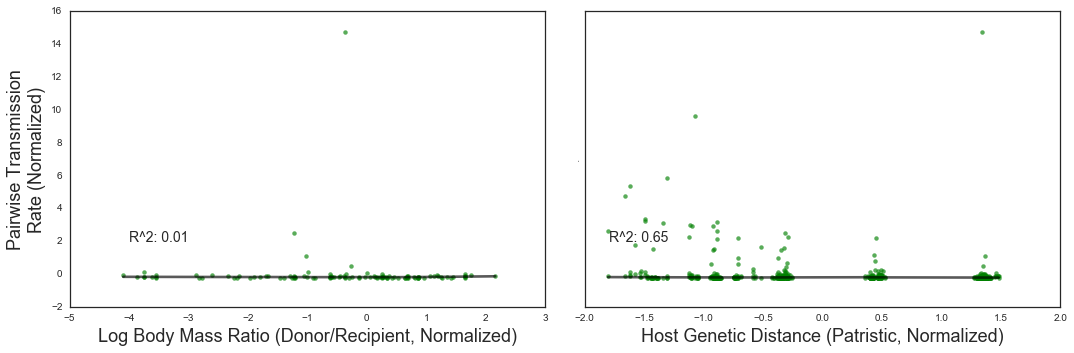

In [58]:
fig, (bmr_ax, hgd_ax) = plt.subplots(figsize=(15,5),nrows=1,ncols=2,sharey=True, facecolor='w') # Note shared Y axis

bmr_line = sns.regplot(pd.Series(bmr_vals), pd.Series(ar_vals), lowess=True, # LOWESS line ends up ~ the same as the regression line
                       ax=bmr_ax, color='g', scatter_kws={'alpha': 0.65}, line_kws = {'color':'k', 'alpha': 0.65})
hgd_line = sns.regplot(pd.Series(hgd_vals), pd.Series(ar_vals), lowess=True, 
                       ax=hgd_ax, color='g', scatter_kws={'alpha': 0.65}, line_kws = {'color':'k', 'alpha': 0.65})

hgd_ax.set_xlabel('Host Genetic Distance (Patristic, Normalized)', size=18)
bmr_ax.set_ylabel('Pairwise Transmission\nRate (Normalized)', size=18)
bmr_ax.set_xlabel('Log Body Mass Ratio (Donor/Recipient, Normalized)', size=18)
hgd_ax.set_ylabel(None, size=0)


bmr_reg_x = bmr_line.get_lines()[0].get_xdata()
bmr_reg_y = bmr_line.get_lines()[0].get_ydata()
hgd_reg_x = hgd_line.get_lines()[0].get_xdata()
hgd_reg_y = hgd_line.get_lines()[0].get_ydata()

bmr_slope, bmr_intercept, bmr_r_value, bmr_p_value, bmr_std_err = scipy.stats.linregress(bmr_reg_x, bmr_reg_y)
hgd_slope, hgd_intercept, hgd_r_value, hgd_p_value, hgd_std_err = scipy.stats.linregress(hgd_reg_x, hgd_reg_y)

bmr_ax.text(-4, 2, 'R^2: %.2f'%bmr_r_value**2, fontsize=14)
hgd_ax.text(-1.8, 2, 'R^2: %.2f'%hgd_r_value**2, fontsize=14)

sns.set_style('white')
# bmr_ax.set_xlim(-1, 9)
# hgd_ax.set_xlim(-1, 2)
plt.tight_layout()
plt.show()

### Figure 4: Cross-species transmission is driven by exposure and constrained by host genetic distance.  
LOWESS fit illustrating the relationship between the asymmetric transmission rates between each pair of hosts vs. **A** the ratio of body masses (donor / recipient host) and **B** the genetic distance between the hosts.

In [59]:
import scipy

bmr_reg_x = bmr_line.get_lines()[0].get_xdata()
bmr_reg_y = bmr_line.get_lines()[0].get_ydata()
hgd_reg_x = hgd_line.get_lines()[0].get_xdata()
hgd_reg_y = hgd_line.get_lines()[0].get_ydata()

bmr_slope, bmr_intercept, bmr_r_value, bmr_p_value, bmr_std_err = scipy.stats.linregress(bmr_reg_x, bmr_reg_y)
hgd_slope, hgd_intercept, hgd_r_value, hgd_p_value, hgd_std_err = scipy.stats.linregress(hgd_reg_x, hgd_reg_y)

print 'BMR: ', bmr_slope, bmr_intercept, bmr_r_value**2, bmr_p_value, bmr_std_err
print 'HGD: ', hgd_slope, hgd_intercept, hgd_r_value**2, hgd_p_value, hgd_std_err

BMR:  0.000553814393689 -0.188097112771 0.00657499079928 0.393225445132 0.0006461341857
HGD:  -0.00501938116846 -0.2123980951 0.645780591115 4.74226337971e-126 0.00015851213485
